# Forms

## Libraries

In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from matplotlib import gridspec

from glob import glob
from random import shuffle

from skimage import io
from skimage import color
from skimage import filters
from skimage import feature
from skimage import data

from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## HoG

_**H**istogram **o**f **G**ragient_ is a well known feature descriptor introduced in 2005 by peoples from INRIA.

[There](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) is a paper about how the HoG descriptor could be used for pedestrian detection.

The HoG feature descriptor is made of several steps:

- gradient computation (measure how much the image vary horitontaly and verticaly)
![image gradient from wikipedia](./imgs/Intensity_image_with_gradient_images.png)

(original image, gradient in x axis, gradient in y axis)


- direction and magnitude computation
![image direction and magnitude computation](./imgs/hog-cell-gradients-768x432.png)

- histogram creation (build a small histogram about how much the direction vary in the block)
![image histogram creation](./imgs/HOG-calculation-a-gradients-in-a-cell-b-histogram-of-gradients.png)

- block normalization (normalize each block to be light invariant)

We will see bellow how the HoG descriptor of an image look like...

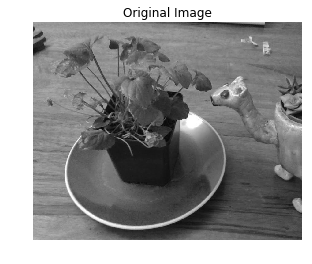

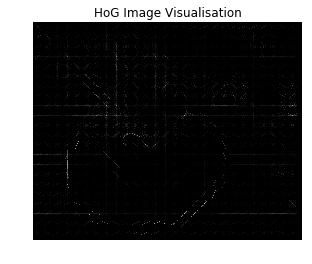

shape of the original image :  (711, 879)
shape of the hog descriptor of this image :  (153600,)


In [2]:
img     = io.imread("imgs/sample.png", as_grey=True)
hog_descriptor, hog_visualization = feature.hog(
    img, 
    orientations=8,             #how many bins in the histogram
    pixels_per_cell=(32, 32),   #size of the cells inside a block
    cells_per_block=(8,   8),   #how many cells in a block
    visualise=True,             #to return a visualisation of the HoG feature
    feature_vector=True
)

plt.title("Original Image")
plt.axis("off")
plt.imshow(img, cmap='gray')
plt.show()

plt.title("HoG Image Visualisation")
plt.axis("off")
plt.imshow(hog_visualization, cmap='gray')
plt.show()

print("shape of the original image : ", img.shape)
print("shape of the hog descriptor of this image : ", hog_descriptor.shape)

**Exercice**: _try to vary the number of blocks, the number of cells and the number of orientation and see how the out shape vary_...

Now let's build a simple car detector with a car dataset available online:

- positives [link](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
- negatives [link](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

Download both dirs and unzip them in the `imgs/` directory, this should look like this :

![look](./imgs/look.png)

Here are some :

- positives:

![pos1](./imgs/pos1.png)
![pos2](./imgs/pos2.png)
![pos3](./imgs/pos3.png)

- negatives:

![neg1](./imgs/neg1.png)
![neg2](./imgs/neg2.png)
![neg3](./imgs/neg3.png)

In [3]:
positives_imgs_path = glob("imgs/vehicles/*/*.png")      #glob("imgs/positives/*.png")
negatives_imgs_path = glob("imgs/non-vehicles/*/*.png") #glob("imgs/negatives/*.jpg")

shuffle(positives_imgs_path)
shuffle(negatives_imgs_path)

MAX_SAMPLES = 1000

In [4]:
def preprocess_img(im_path, nb_orientation=8, pixels_per_cell=(8, 8), cells_per_block=(4, 4)):
    im = io.imread(im_path, as_grey=True)
    hog_descriptor = feature.hog(
        im, 
        orientations=nb_orientation, 
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualise=False,
        feature_vector=True
    )
    return hog_descriptor

In [5]:
#compute the HoG Descriptor of each image
positives_descriptors = list(map(preprocess_img, positives_imgs_path[:MAX_SAMPLES])) #only take MAX_SAMPLES samples
negatives_descriptors = list(map(preprocess_img, negatives_imgs_path[:MAX_SAMPLES]))

In [6]:
data_set = list(zip(
    positives_descriptors + negatives_descriptors, 
    [1] * len(positives_descriptors) + [0] * len(negatives_descriptors)
))

shuffle(data_set)

x_data, y_data = list(zip(*data_set))

#make training test
x_train = x_data[:int(len(x_data) * .8)]
y_train = y_data[:int(len(x_data) * .8)]

x_test  = x_data[int(len(x_data) * .8):]
y_test  = y_data[int(len(x_data) * .8):]

In [7]:
#train a SMV classifier (this can take a while...)
clf = LinearSVC()
clf.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [8]:
print("Accuracy : {} %".format((clf.predict(x_test) == y_test).mean() * 100))

Accuracy : 94.75 %


**Exercice**: _try to change:_
 - the params of the HoG descriptor extractor
 - the params of the linear SVM classifier
 - the number of training samples
    
_What's your best score ?_

In [ ]:
#TODO: some exploration...

## Haar Features

### The Features

The Haars features became particulary successfull since Viola & Jones introduced them in their work about real time face detection ([link](http://www.merl.com/publications/docs/TR2004-043.pdf) to the paper).
Indeed, with a simple computationnal trick (dynamic programming) and boosting, they permitted to speedup the computationnal time.

First of all let's see how does those features looks like and how to compute them.

![img haar features](./imgs/haar_features.jpg)

The can be combined and look like that :

![img combined haar](./imgs/features2.png)

When computed on a patch of the same size of the feature, all the white part is added and all the black part is substracted.

They can be seen as an approximation of the Gabor filters: 

![approximation of gabor filter](./imgs/main-qimg-837c0f67f5ef3929dae787a14b863fb8-c.jpg)

At leat, this is how they can be used in face detection :

![haar face detection](./imgs/main-qimg-667ef28b0bfb903b1af6452aff6a247e.png)

### The Integral Image

Because the filters allways contains the same value, the computation can be speeded up with a simple trick : the **Integral Image**.

The integral image is the image with the cumulative sum of all pixels allready seens from the left-top corner.
It is computer like this : 

![integram image computation](./imgs/mtPHG.png)

Also, with this new image, we can get the sum of pixels of any rectangle in this image with only 4 operations :

![sum of rectangle integral image](./imgs/intimage.png)


**Exercice**: _build a function to compute the integral image of a grayscale image of any size._

_Compare result with the example (upper)..._

**Exercice**: _see how the integral image can help to solve [this](http://www.spoj.com/problems/CUTOUT/) problem._

_See how the Integral Image is a powerfull approach compared to a naïve solution on the following problem:_

1. build a 20x20 matrix containing only zeros (`np.zeros((20, 20))`)
2. set randomly 10 pixels with the value 1
3. find where is the **greatest square** you can put in this matrix **which doesn't contains any one**.

Good luck ! 😃

In [ ]:
#TODO: solve the problem... =)

Now, take a look to the sklearn [example](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html) about face classification with Haar features...

And, to conclude: with those new features / object descriptor you can build a much more power full object detector with the sliding window (and pyramid) approach seen [previously](../2_object_detection/2_object_detection.ipynb) !